In [1]:
# Step 1: Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Step 2: Set up paths and parameters
# Update this with the path to your dataset directory
DATA_DIR = 'dataset'  
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 15

Found 15 classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']
Bear: 125 images
Bird: 137 images
Cat: 123 images
Cow: 131 images
Deer: 127 images
Dog: 122 images
Dolphin: 129 images
Elephant: 133 images
Giraffe: 129 images
Horse: 130 images
Kangaroo: 126 images
Lion: 131 images
Panda: 135 images
Tiger: 129 images
Zebra: 137 images


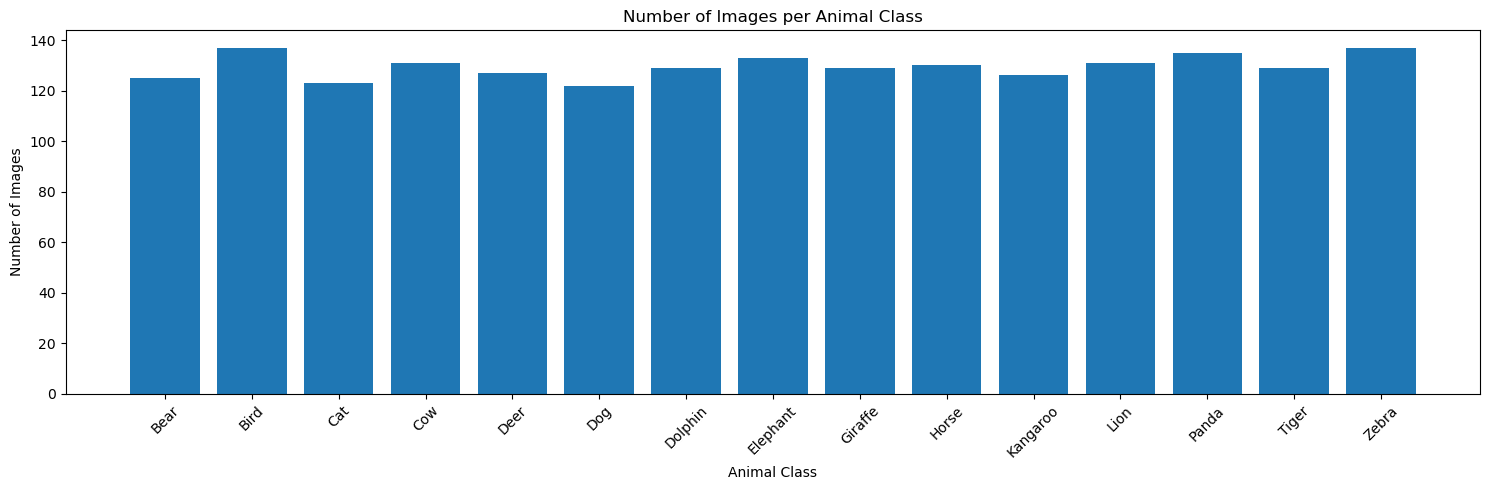

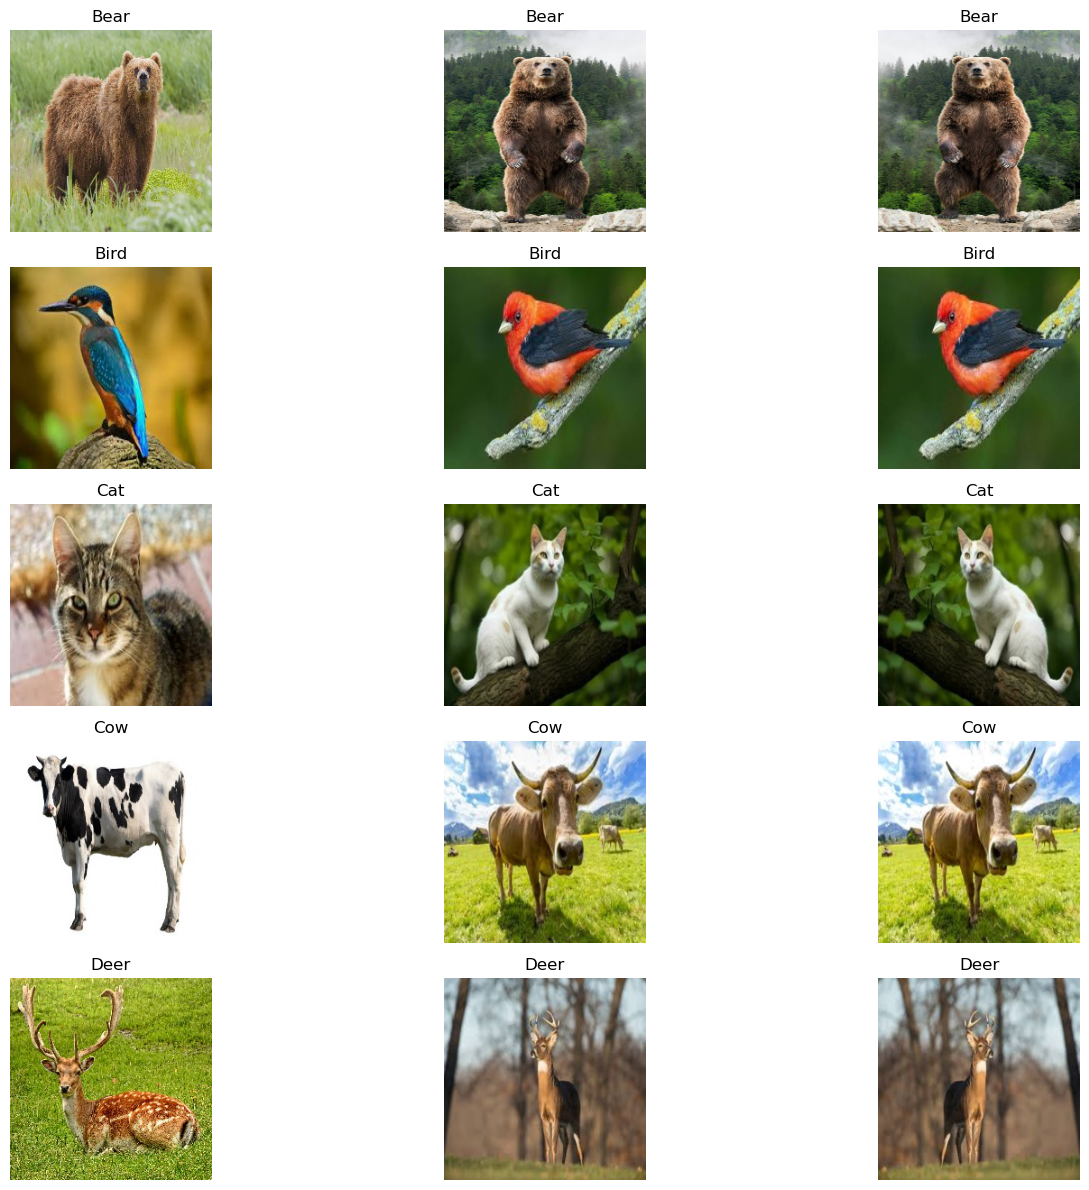

In [3]:
# Step 3: Data exploration
# Get all class names (folder names)
classes = sorted([folder for folder in os.listdir(DATA_DIR) 
                 if os.path.isdir(os.path.join(DATA_DIR, folder))])
print(f"Found {len(classes)} classes: {classes}")

# Count images per class
class_counts = {}
for class_name in classes:
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count
        print(f"{class_name}: {count} images")

# Plot distribution
plt.figure(figsize=(15, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title('Number of Images per Animal Class')
plt.xlabel('Animal Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

# Display sample images
plt.figure(figsize=(15, 12))
for i, class_name in enumerate(list(class_counts.keys())[:5]):  # Show samples from first 5 classes
    class_path = os.path.join(DATA_DIR, class_name)
    images = os.listdir(class_path)[:3]  # Get first 3 images
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = plt.imread(img_path)
        plt.subplot(5, 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(f'{class_name}')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Step 4: Data preprocessing and augmentation
# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Just rescaling for validation
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create train and validation generators
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Class mappings: {train_generator.class_indices}")

Found 1561 images belonging to 15 classes.
Found 383 images belonging to 15 classes.
Training samples: 1561
Validation samples: 383
Class mappings: {'Bear': 0, 'Bird': 1, 'Cat': 2, 'Cow': 3, 'Deer': 4, 'Dog': 5, 'Dolphin': 6, 'Elephant': 7, 'Giraffe': 8, 'Horse': 9, 'Kangaroo': 10, 'Lion': 11, 'Panda': 12, 'Tiger': 13, 'Zebra': 14}


In [5]:
# Step 5: Create the model using transfer learning
# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 3,049,039 (11.63 MB)

 Trainable params: 791,055 (3.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Step 6: Train the model
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


C:\Users\jalis\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.3666 - loss: 2.1444 - val_accuracy: 0.8438 - val_loss: 0.6015
Epoch 2/10
 1/48 ━━━━━━━━━━━━━━━━━━━━ 25s 539ms/step - accuracy: 0.8125 - loss: 0.6865

C:\Users\jalis\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.8125 - loss: 0.6865 - val_accuracy: 0.8324 - val_loss: 0.6076
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 973ms/step - accuracy: 0.7769 - loss: 0.7068 - val_accuracy: 0.8438 - val_loss: 0.4763
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9375 - loss: 0.3005 - val_accuracy: 0.8438 - val_loss: 0.4939
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 930ms/step - accuracy: 0.7934 - loss: 0.6365 - val_accuracy: 0.8580 - val_loss: 0.4434
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8750 - loss: 0.5737 - val_accuracy: 0.8722 - val_loss: 0.4254
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 903ms/step - accuracy: 0.8606 - loss: 0.4499 - val_accuracy: 0.8778 - val_loss: 0.3939
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.8438 - loss: 0.3608 - val_accuracy: 0.8835 - val_loss: 0.3846
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 44s 911ms/step - accuracy: 0.8591 - loss: 0.4233 - val_accuracy: 0.8693 - 

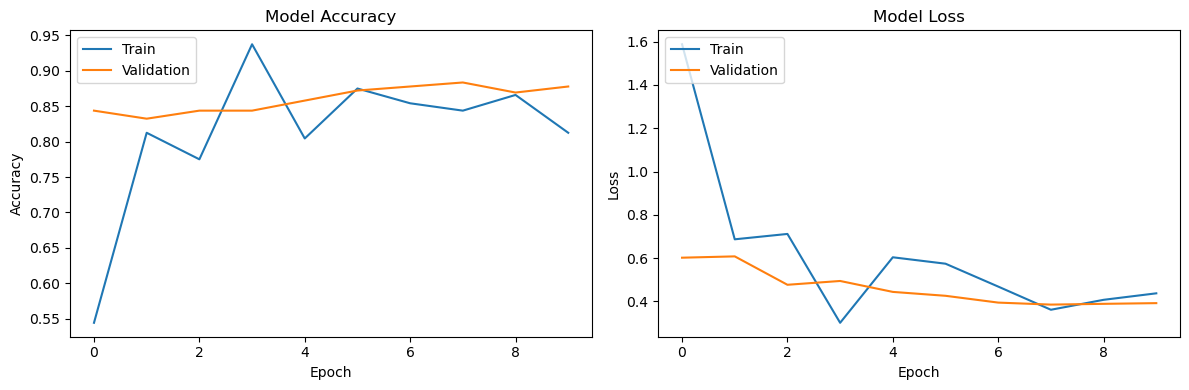

In [7]:
# Step 7: Plot the training results
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
# Step 8: Fine-tune the model
# Unfreeze some of the layers in the base model
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,  # Few more epochs for fine-tuning
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8357 - loss: 0.4832 - val_accuracy: 0.8409 - val_loss: 0.5584
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8750 - loss: 0.3226 - val_accuracy: 0.8438 - val_loss: 0.5638
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 989ms/step - accuracy: 0.8880 - loss: 0.3256 - val_accuracy: 0.8409 - val_loss: 0.5729
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9062 - loss: 0.2134 - val_accuracy: 0.8409 - val_loss: 0.5790
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 972ms/step - accuracy: 0.9123 - loss: 0.2689 - val_accuracy: 0.8551 - val_loss: 0.5170


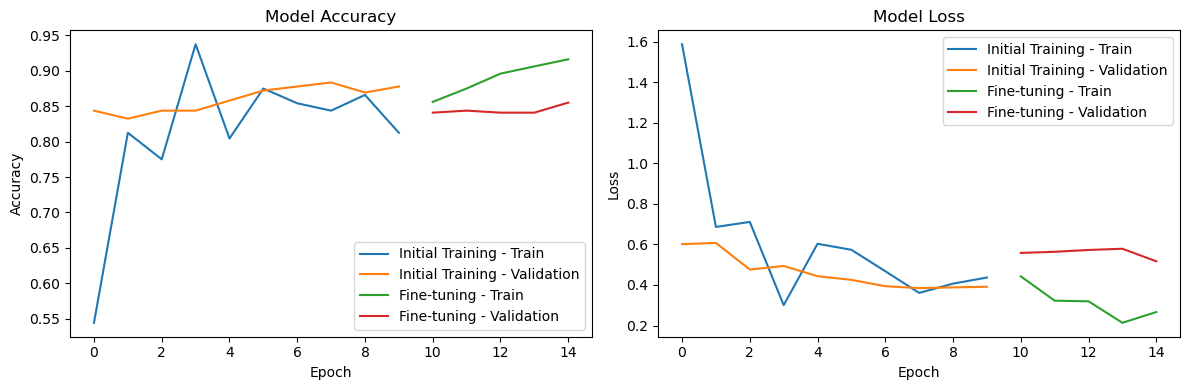

In [9]:
# Step 9: Plot results after fine-tuning
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# Initial training
plt.plot(history.history['accuracy'], label='Initial Training - Train')
plt.plot(history.history['val_accuracy'], label='Initial Training - Validation')

# Fine-tuning - offset epochs
initial_epochs = len(history.history['accuracy'])
plt.plot(
    np.arange(initial_epochs, initial_epochs + len(history_fine.history['accuracy'])),
    history_fine.history['accuracy'],
    label='Fine-tuning - Train'
)
plt.plot(
    np.arange(initial_epochs, initial_epochs + len(history_fine.history['val_accuracy'])),
    history_fine.history['val_accuracy'],
    label='Fine-tuning - Validation'
)

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
# Initial training
plt.plot(history.history['loss'], label='Initial Training - Train')
plt.plot(history.history['val_loss'], label='Initial Training - Validation')

# Fine-tuning - offset epochs
plt.plot(
    np.arange(initial_epochs, initial_epochs + len(history_fine.history['loss'])),
    history_fine.history['loss'],
    label='Fine-tuning - Train'
)
plt.plot(
    np.arange(initial_epochs, initial_epochs + len(history_fine.history['val_loss'])),
    history_fine.history['val_loss'],
    label='Fine-tuning - Validation'
)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Step 10: Save the model
model.save('animal_classification_model.h5')

# Save class labels - invert the class indices dictionary
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

with open('animal_classes.txt', 'w') as f:
    for i in range(len(class_labels)):
        f.write(f"{class_labels[i]}\n")

print("Model and class labels saved successfully.")

Model and class labels saved successfully.


In [11]:
# Step 11: Create a function for making predictions
def predict_image(image_path):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    
    # Display top 3 predictions
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]
    top_3_classes = [class_labels[i] for i in top_3_idx]
    top_3_probs = [predictions[0][i] * 100 for i in top_3_idx]
    
    for i in range(3):
        print(f"{i+1}. {top_3_classes[i]}: {top_3_probs[i]:.2f}%")
    
    return predicted_class, confidence

Enter the path to an animal image:  images.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


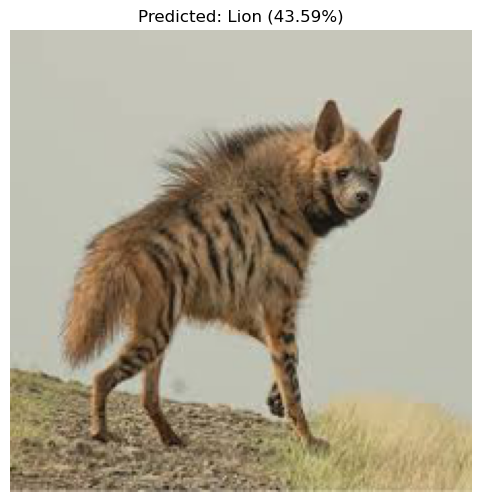

1. Lion: 43.59%
2. Cat: 39.57%
3. Bear: 13.42%


In [13]:
# Step 12: Simple function for manual path input prediction
def predict_from_path():
    """
    Function to make predictions on images from a file path.
    This is a simple approach that works in any environment.
    """
    path = input("Enter the path to an animal image: ")
    try:
        predict_image(path)
    except Exception as e:
        print(f"Error: {e}")
        print("Please check the file path and try again.")

predict_from_path()